# Noise ceiling function

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import scipy.spatial as sp
import scipy.optimize as so
import random

%matplotlib inline

# Import datasets

In [15]:
y_res = pd.read_csv('y_res1.csv', header=None)

col_names=['x', 'y', 'z', 'depth']
location=pd.read_csv('location.csv',names=col_names)

# View y_res.csv

In [16]:
print(y_res.shape)
y_res.head()

(3488, 933)


,0,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,-26.5160,26.62300,3.0929,-19.6980,-9.94000,13.3980,31.4680,39.0380,-7.9090,30.595,...,-10.58400,-20.8480,-0.41171,-23.511,-5.4647,-34.993,-45.190,7.9113,-6.2091,19.889
1,15.0100,9.73560,20.7270,14.5580,-14.63900,-48.0150,-13.7400,2.3699,19.0750,-14.124,...,22.24100,-10.2100,-0.78411,-37.818,-22.0660,-31.371,-47.510,-5.1689,25.4960,-10.574
2,-1.0803,14.36800,23.3040,-4.7900,-0.81247,-8.3198,29.9200,-9.7703,13.5050,-17.230,...,-26.06400,10.7070,-20.45600,-24.053,-9.7981,-49.775,-40.405,14.2920,-22.0380,37.135
3,-21.6400,-19.04700,-27.3580,13.7920,-13.71200,-13.1390,4.0264,-1.5494,20.5230,11.375,...,12.37900,-8.8534,-21.94300,-23.446,-32.8570,-55.697,-48.037,23.6720,-16.6120,26.502
4,-9.7808,0.83407,-23.7150,-5.2596,-19.04100,-8.0778,12.6460,-37.7300,-8.8727,18.778,...,0.47902,-25.2330,-33.06700,-23.311,-8.5716,-23.852,-70.533,27.3110,-8.6012,16.731


# View location.csv

In [17]:
print(location.shape)
location.head()

(933, 4)


,x,y,z,depth
0,-58.710,-64.143,-12.913,1.03130
1,-60.710,-64.135,-12.875,0.94725
2,-58.686,-62.365,-11.998,1.08950
3,-54.706,-66.854,-12.124,1.64540
4,-56.706,-66.845,-12.087,1.12620


# Define a function get correlation from any given y_res

In [18]:
def get_corr(Y_res):
    
    #obtaining the correlation between voxels
    corr=Y_res.corr(method ='pearson')
    corr_tril=np.tril(corr,k=-1)
    Corr=corr_tril[np.nonzero(corr_tril)]
    Corr=Corr.reshape(-1,1)
    Corr=pd.DataFrame(Corr)
    return Corr

# Define a function get design matrix X from dataframe: location
### exp_model: $Corr=\beta_0+\beta_1*exp(-dist*\gamma)+\beta_2*dep1+\beta_3*dep2+\beta4*dep1*dep2$
### power_model: $Corr=\beta_0+\beta_1*eta^{dist}+\beta_2*dep1+\beta_3*dep2+\beta4*dep1*dep2$

In [19]:
def get_design_matrix(Location,gamma=0.2,eta=0.8):

    #Obtaining the distance between voxels
    dist_matrix=sp.distance_matrix(Location.iloc[:,0:2],Location.iloc[:,0:2])
    dist_tril=np.tril(dist_matrix,k=-1)
    rowid,colid=np.nonzero(dist_tril)
    dist=dist_tril[rowid,colid]
    dist=dist.reshape(-1,1)
    
    exp_dist=np.exp(-dist*gamma)
    power_dist=[eta**k for k in dist]

    #Obtaining the depth from the 1st voxel
    dep1=Location.depth[rowid]
    dep1=dep1.values
    dep1=dep1.reshape(-1,1)

    #obtaining depth from the 2ed voxel
    dep2=Location.depth[colid]
    dep2=dep2.values
    dep2=dep2.reshape(-1,1)

    dep1_2=dep1*dep2

    #Creat the design matrix
    X_exp=np.concatenate((exp_dist,dep1,dep2,dep1_2),axis=1)
    names_exp=['exp_dist','dep1','dep2','dep12']
    X_exp=pd.DataFrame(X_exp,columns=names_exp)
    
    X_power=np.concatenate((power_dist,dep1,dep2,dep1_2),axis=1)
    names_power=['power_dist','dep1','dep2','dep12']
    X_power=pd.DataFrame(X_power,columns=names_power)
    
    #make design matrices as a dictionary
    design_dict={"exp": X_exp,
                "power": X_power}
    
    #return a dictionary with model names and corresponding design matrix X
    return design_dict

## Function model_evaluation
### taking input: noise matrix, model (design matrix X), evaluation method , num of runs; 
### returning: the $R^2$ for each of the model,  lower bound  and upper bound of noise ceiling

In [20]:
def model_evaluation(Y_res, design_matrix=None, evaluation_method="R_sqr",num_run=8):
    #design_matrix: a dictionary of a list of design matrices (with name as index name)

    #split Y_res into n equal pieces according to the number of runs (n)
    
    r_sqr_low=np.zeros(num_run)
    r_sqr_up=np.zeros(num_run)
    kf = KFold(n_splits=8)
    i=0
    for train_index, test_index in kf.split(Y_res):
        
        Corr_train=get_corr(Y_res.loc[train_index])
        Corr_test=get_corr(Y_res.loc[test_index])
        Corr_allrun=get_corr(Y_res)
        
        ESS_lowbound=np.sum((Corr_train-Corr_test)**2)
        ESS_upbound=np.sum((Corr_allrun-Corr_test)**2)
        mu=np.mean(Corr_test)
        TSS=np.sum((Corr_test-mu)**2)
        
        if evaluation_method=="R_sqr":
            
            r_sqr_low[i]=1-ESS_lowbound/TSS
            r_sqr_up[i]=1-ESS_upbound/TSS
               
    R_sqr_lowbound=np.mean(r_sqr_low)
    R_sqr_upbound=np.mean(r_sqr_up)
    noise_ceilling_bounds=[R_sqr_lowbound,R_sqr_upbound]    

    r_sqr_model={}
    if design_matrix!=None:       
      
        for model_key in design_matrix:
            linmodel = LinearRegression().fit(design_matrix[model_key], Corr_allrun)
            r_sqr_model[model_key]=linmodel.score(design_matrix[model_key], Corr_allrun)
            
    return [r_sqr_model,noise_ceilling_bounds]

### Test function

In [21]:
model_dict=get_design_matrix(location)
results_model_evaluat=model_evaluation(y_res, model_dict)
results_model_evaluat

[{'exp': 0.13405406245374096, 'power': 0.13426607148801306},
 [0.010724094587985039, 0.033800725585128075]]

## Creating a graph showing the result from function: model_evaluation()

In [22]:
def barplot_noisebounds(result_model_evaluation, plot_type="bar"):
    results_dist=result_model_evaluation[0]
    model_name=[key for key in results_dist]
    r_sqr=[results_dist[key] for key in results_dist]
    
    lowbound, upbound=result_model_evaluation[1]
    
    if plot_type=="bar":
        plt.figure(figsize=(10,6))
        ax=sns.barplot(model_name,r_sqr)
        #change the bar width 
        widthbars=[0.3,0.3]
        for bar ,newwidth in zip(ax.patches, widthbars):
            x=bar.get_x()
            width=bar.get_width()
            center=x+width/2
            bar.set_x(center-newwidth/2.)
            bar.set_width(newwidth)
        #ax.set(ylim=(0, 0.2))
        ax.axhline(lowbound, ls='--',color="gray")
        ax.axhline(upbound, ls='--',color="gray")

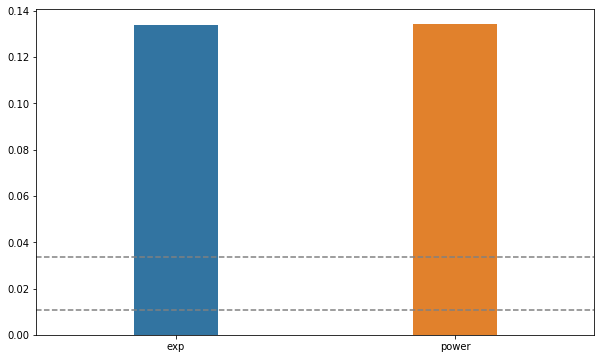

In [23]:
barplot_noisebounds(results_model_evaluat)